<a href="https://colab.research.google.com/github/racs2019/Data-Science-Basics-Series/blob/main/Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ridge Regression

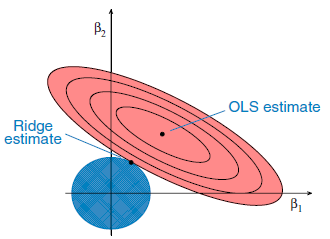

This assignment focuses on creating a batch gradient decent ridge regression model from scratch. Ridge regression is a simple yet classical method for regularizing or 'shrinking' the coefficients of the model. This is achieved by modifying the loss function to focus on balancing finding the optimal coefficients with reducing the complexity of the model.



---



##Data, Parameter, and Functions Preparation

This section prepares the data from the csv file into numpy arrays and sets up the design and response vectors for vector multiplication in the gradient decent ridge regression algorithm. During this process, any categorical features are transformed to a binary (numerical) representation, and the learning rate (alpha parameter) is defined. Next, the design and response vectors are used to create different dataset cohorts for the full dataset and for the 5-fold cross validation training and validation datasets. Finally, this section creates functions to initialize a beta vector with random values from a uniform distribution between [-1,1), and standardize and center the different data cohorts created after splitting into the full dataset and the 5-fold cross validation dataset. The main ridge regression function which updates the beta parameters is also included in this section.

In [ ]:
#Dependencies
import pandas as pd
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import numpy as np
import warnings

#Data csv
url = 'https://raw.githubusercontent.com/racs2019/CAP-5625-A2-Data/main/Credit_N400_p9.csv'
df = pd.read_csv(url)

In [ ]:
#Display dataset dataframe
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331


In [ ]:
#Convert cagetory features (gender, student, married) to binary encoding
warnings.filterwarnings('ignore')

for x in range(0,len(df)):
  if df['Gender'][x] == 'Female':
    df['Gender'][x] = 0
  elif df['Gender'][x] == 'Male':
    df['Gender'][x] = 1

for x in range(0,len(df)):
  if df['Student'][x] == 'No':
    df['Student'][x] = 0
  elif df['Student'][x] == 'Yes':
    df['Student'][x] = 1

for x in range(0,len(df)):
  if df['Married'][x] == 'No':
    df['Married'][x] = 0
  elif df['Married'][x] == 'Yes':
    df['Married'][x] = 1

In [ ]:
#Display dataset after converting categorical features
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,1,0,1,333
1,106.025,6645,483,3,82,15,0,1,1,903
2,104.593,7075,514,4,71,11,1,0,0,580
3,148.924,9504,681,3,36,11,0,0,0,964
4,55.882,4897,357,2,68,16,1,0,1,331


In [ ]:
#Learning rate
alpha = 1 * (10**(-5))

#Response matrix from dataframe
ytemp = df['Balance'].to_numpy()
y = np.ones((400,1))
y[:,0] = ytemp
y = np.array(y, dtype='float')

#Design matrix from dataframe
x = df[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender', 'Student', 'Married']].to_numpy()
x = np.array(x, dtype='float')

In [ ]:
#----------------------------------------------------
#Split dataset into 5-fold cross validation datasets
#----------------------------------------------------

#Full dataset used to train model on all data
x_full = cp.deepcopy(x)
y_full = cp.deepcopy(y)

#Randomly shuffles and splits into 5 batches/folds the reponse and design vectors the same way
shuffler = np.random.permutation(len(x))
Xb = x[shuffler]
Yb = y[shuffler]
x_split = np.split(Xb, 5)
y_split = np.split(Yb, 5)

#x_training_five_fold and y_training_five_fold contain the traning datasets for 5 fold CV
x_training_five_fold = [[], [], [], [], []]
y_training_five_fold = [[], [], [], [], []]

#x_validation_five_fold and y_validation_five_fold contains the validation datasets
x_validation_five_fold = [[], [], [], [], []]
y_validation_five_fold = [[], [], [], [], []]

#Performs the 5-fold cross validation split
for i in range(5):
  temp_x = []
  temp_y = []
  flag = 0
  for j in range(5):
    if j != i:
      if flag == 0:
        temp_x = x_split[j]
        temp_y = y_split[j]
        flag = 1
      elif flag == 1:
        temp_x = np.append(temp_x, x_split[j], axis=0)
        temp_y = np.append(temp_y, y_split[j], axis=0)
    else:
      x_validation_five_fold[i] = x_split[j]
      y_validation_five_fold[i] = y_split[j]
  x_training_five_fold[i] = temp_x
  y_training_five_fold[i] = temp_y

In [ ]:
#------------------------------------------------
#Functions to standardize and center the datasets
#------------------------------------------------

#standardization function for traning dataset
def standardize(data):
  mean_array = np.mean(data, axis=0)
  std_array = np.std(data, axis=0)

  for i in data:
    for j in range(0,9):
      i[j] = (i[j] - mean_array[j])/std_array[j]

#standardization function for validation dataset, uses mean/std from training dataset
def standardize_val(data, validation):
  mean_array = np.mean(data, axis=0)
  std_array = np.std(data, axis=0)

  for i in validation:
    for j in range(0,9):
      i[j] = (i[j] - mean_array[j])/std_array[j]

#Center function for traning dataset
def center(data):
  mean = np.mean(data, axis=0)
  for i in range(0, len(data)):
    data[i] = data[i] - mean

#Center function for validation dataset, uses mean from training dataset
def center_val(data, validation):
  mean = np.mean(data, axis=0)
  for i in range(0, len(validation)):
    validation[i] = validation[i] - mean

In [ ]:
#Perform centering and standardization on traning dataset and validation dataset (using mean and std from training data)
for i in range(0,5):
  standardize_val(x_training_five_fold[i], x_validation_five_fold[i])
  standardize(x_training_five_fold[i])

  center_val(y_training_five_fold[i], y_validation_five_fold[i])
  center(y_training_five_fold[i])

standardize(x_full)
center(y_full)

In [ ]:
#Function to initalize parameter vector beta as random variables from uniform distribution [-1,1)
def init_beta():
  betatemp = np.random.uniform(-1,1,9)
  beta = np.ones((9,1))
  beta[:,0] = betatemp
  return(beta)

In [ ]:
#-----------------------------------------------------
#Ridge regression using batch gradient decent function
#-----------------------------------------------------

#Takes a beta vector, a λ parameter, and the deisgn and response vectors as input and returns updated beta
def ridge_regression(beta, lmbda, x, y):
  for i in range (0,100000):
    beta = beta - (2*alpha) * ((lmbda * beta) - np.dot(np.transpose(x), (y - np.dot(x, beta))))
  return beta

##Ridge Regression on Full Dataset with Varying λ *(Deliverable 1)*

This section runs ridge regression on the full dataset for each value of λ = [10^-2, 10^-1, 10^0, ..., 10^4]. The resulting beta vector from the respective λ value is then stored in an array and plotted to show how each feature/beta coefficient changes as we increased the λ value. The graph demonstrates how the features 'shrink' and tend towards zero as the λ value is increased. However, unlike lasso, ridge regression does not perform explicit feature selection and keeps all the features, although some are reduced to very small coefficients, in an assumption that each feature is important to some degree.

In [ ]:
#Run ridge regression for each value λ = [10^-2, 10^-1, 10^0, ..., 10^4] and store beta values
beta_array = []
for i in range(0, 7):
  beta = init_beta()
  beta = ridge_regression(beta, 10**(i-2), x_full, y_full)
  beta_array.append(beta)

In [ ]:
#Convert the array of all beta values for each λ value into an array of values for a single beta as λ increases
lmbda_array = [[], [], [], [], [], [], [], [], []]
for x in beta_array:
  for i in range(0,9):
    lmbda_array[i].append(x[i])

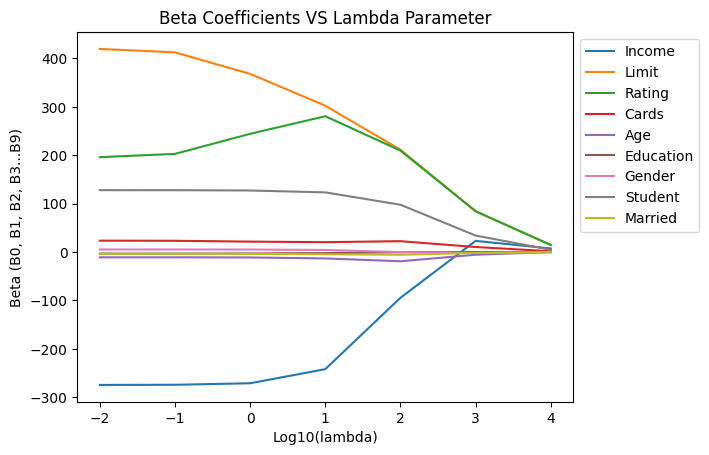

In [ ]:
#Plot the effect of λ value on the beta value of each feature/beta parameter
label = ["Income", "Limit", "Rating", "Cards", "Age", "Education", "Gender", "Student", "Married"]
for i in range(0,9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4], lmbda_array[i], label=label[i])
plt.title("Beta Coefficients VS Lambda Parameter")
plt.xlabel("Log10(lambda)")
plt.ylabel("Beta (B0, B1, B2, B3...B9)")
leg = plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.show()

##5-Fold Cross Validation and CV Error with Varying λ *(Deliverable 2-3)*

This section trains the 5-fold cross validation dataset on the ridge regression model and calculates the 5-fold cross-validation MSE using the validation dataset. The model is run on the cross-validation dataset for each value of λ = [10^-2, 10^-1, 10^0, ..., 10^4], and the MSE is computed for each value of λ. Finally, the CV MSE is plotted against the respective λ value, illustrating that significantly increasing the lambda value resulted in worse performance as important coefficients were being forcibly shrunk towards zero.

In [ ]:
#Run ridge regression with five fold cross validation for each value λ = [10^-2, 10^-1, 10^0, ..., 10^4]
#and store beta values. Store validation MSE from each varying λ iteration into an array for plotting.
MSE_array = [0, 0, 0, 0, 0, 0, 0]
for j in range(0, 7):
  for i in range(0, 5):
    beta = init_beta()
    beta = ridge_regression(beta, 10**(j-2), x_training_five_fold[i], y_training_five_fold[i])
    MSE = (np.dot((y_validation_five_fold[i] - np.dot(x_validation_five_fold[i], beta)).transpose(), (y_validation_five_fold[i] - np.dot(x_validation_five_fold[i], beta))))/(len(y_validation_five_fold[i]))
    MSE_array[j] = MSE_array[j] + MSE
  MSE_array[j] = (MSE_array[j]/5)
  MSE_array[j] = MSE_array[j][0][0]

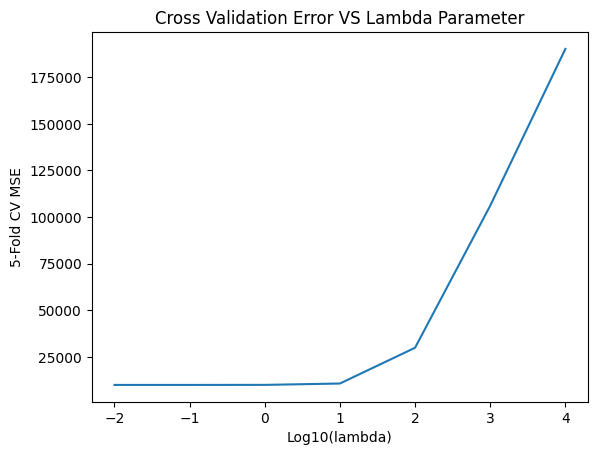

In [ ]:
#Plot the effect of λ value on the cross validation error
plt.plot([-2, -1, 0, 1, 2, 3, 4], MSE_array)
plt.title("Cross Validation Error VS Lambda Parameter")
plt.xlabel("Log10(lambda)")
plt.ylabel("5-Fold CV MSE")
plt.show()

In [ ]:
#Compute and display final beta values on full dataset with best λ
print('Minimum CV error and respective λ value:\n-----------------------------------')
min_CV = min(MSE_array)
print('CV error: ', min_CV)
print('λ = ', 10**(MSE_array.index(min_CV)-2))

Minimum CV error and respective λ value:
-----------------------------------
CV error:  10031.249459997041
λ =  0.01


##Ridge Regression Using Optimal λ on Full Dataset *(Deliverable 4)*

This final section retrains the ridge regression model on the entire dataset using the optimal λ value of 0.01 found in the previous section when comparing CV MSE. The final beta coefficients are then displayed along with their respective feature labels.

In [ ]:
#Retrain on entire dataset using optimal λ of 0.01
beta = init_beta()
beta = ridge_regression(beta, 0.01, x_full, y_full)

In [ ]:
#Compute and display final beta values on full dataset with best λ
print('Final estimates 𝛽̂ = [𝛽̂1, 𝛽̂2, 𝛽̂3, ..., 𝛽̂9] with best λ (λ=0.01):\n--------------------------------------------------------------------')
print(  '(Income) \t𝛽̂1 = ', beta[0][0], '\n(Limit) \t𝛽̂2 = ', beta[1][0], '\n(Rating) \t𝛽̂3 = ', beta[2][0],
      '\n(Cards) \t𝛽̂4 = ', beta[3][0], '\n(Age) \t\t𝛽̂5 = ', beta[4][0], '\n(Education) \t𝛽̂6 = ', beta[5][0],
      '\n(Gender) \t𝛽̂7 = ', beta[6][0], '\n(Student) \t𝛽̂8 = ', beta[7][0], '\n(Married) \t𝛽̂9 = ', beta[8][0],)

Final estimates 𝛽̂ = [𝛽̂1, 𝛽̂2, 𝛽̂3, ..., 𝛽̂9] with best λ (λ=0.01):
--------------------------------------------------------------------
(Income) 	𝛽̂1 =  -274.6534119763952 
(Limit) 	𝛽̂2 =  419.6383894727285 
(Rating) 	𝛽̂3 =  195.85471435098034 
(Cards) 	𝛽̂4 =  23.447902615449745 
(Age) 		𝛽̂5 =  -10.964984722080247 
(Education) 	𝛽̂6 =  -3.3472593790270606 
(Gender) 	𝛽̂7 =  5.20097254919167 
(Student) 	𝛽̂8 =  127.7835203031118 
(Married) 	𝛽̂9 =  -3.5951261348150383


##Sklearn Ridge Regression *(Extra Credit)*

This section implements ridge regression on the credit balance dataset using the SKlearn machine learning library. After training the model, the mean squared error is computed and the coefficients are reported, serving as a check to our original from-scratch model. Overall, the graphs, MSE, optimal λ value, and the final 𝛽̂ value estimates closely match the values from our from-scratch model, confirming the validity of my model. There are marginal differences between some of the values, but they are insignificant and the result of random train test splits when doing the cross validation, the initial random beta values, and other stochastic factors. Each runtime may produce slightly different results, including different optimal lambda values between from-scratch and library implementations since the MSE values are very close for λ = 0.01 and 0.1, but the results are significantly simmilar enough to validate the from-scratch method.

In [ ]:
##Sklearn ridge regression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

x_sklearn = x_full
y_sklearn = y_full

X_train, X_test, y_train, y_test = train_test_split(x_sklearn, y_sklearn, test_size=0.2, random_state=102)

In [ ]:
beta_array_SKlearn = []
for i in range(0, 7):
  model = Ridge(alpha = 0.01 * (10**i))
  model.fit(x_full,y_full)
  beta_array_SKlearn.append(np.array(model.coef_)[0])

In [ ]:
lmbda_array_SKlearn = [[], [], [], [], [], [], [], [], []]
for i in range(len(beta_array_SKlearn)):
  for j in range(0,9):
    lmbda_array_SKlearn[j].append(beta_array_SKlearn[i][j])

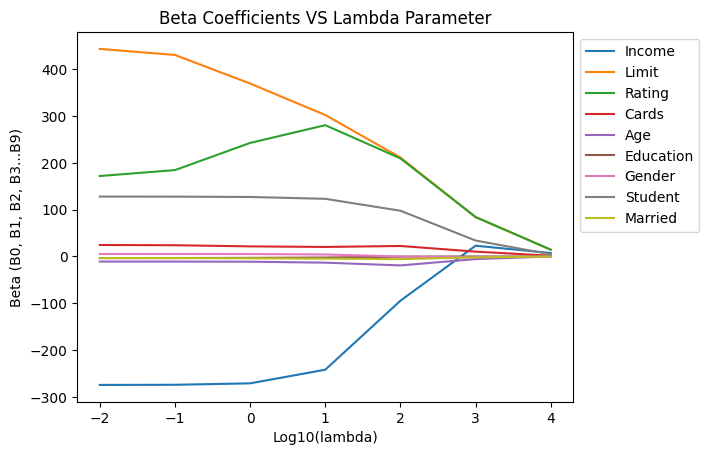

In [ ]:
#Plot the effect of λ value on the beta value of each feature/beta parameter
label = ["Income", "Limit", "Rating", "Cards", "Age", "Education", "Gender", "Student", "Married"]
for i in range(0,9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4], lmbda_array_SKlearn[i], label=label[i])
plt.title("Beta Coefficients VS Lambda Parameter")
plt.xlabel("Log10(lambda)")
plt.ylabel("Beta (B0, B1, B2, B3...B9)")
leg = plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
MSE_array_SKlearn = []
for i in range(0,7):
  model = Ridge(alpha = 0.01 * (10**i))
  model.fit(X_train,y_train)
  predictions = model.predict(X_test)
  MSE_array_SKlearn.append(mean_squared_error(y_test, predictions))

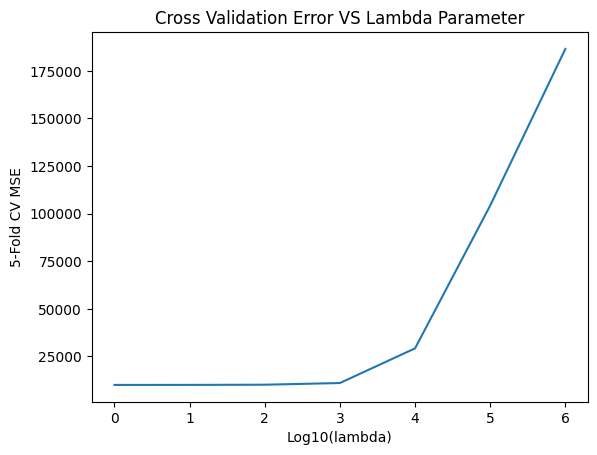

In [ ]:
#Plot the effect of λ value on the cross validation error
plt.plot(MSE_array_SKlearn)
plt.title("Cross Validation Error VS Lambda Parameter")
plt.xlabel("Log10(lambda)")
plt.ylabel("5-Fold CV MSE")
plt.show()

In [ ]:
print('Minimum CV error and respective λ value:\n-----------------------------------')
min_CV = min(MSE_array_SKlearn)
print('CV error: ', min_CV)
print('λ = ', 10**(MSE_array_SKlearn.index(min_CV)-2))

Minimum CV error and respective λ value:
-----------------------------------
CV error:  10048.658699042759
λ =  0.01


In [ ]:
#Compute and display final beta values on full dataset with best λ
model = Ridge(alpha = 0.01)
model.fit(x_full,y_full)
print('Final estimates 𝛽̂ = [𝛽̂1, 𝛽̂2, 𝛽̂3, ..., 𝛽̂9] with best λ (λ=0.01):\n--------------------------------------------------------------------')
print(  '(Income) \t𝛽̂1 = ', np.array(model.coef_)[0][0], '\n(Limit) \t𝛽̂2 = ', np.array(model.coef_)[0][1], '\n(Rating) \t𝛽̂3 = ', np.array(model.coef_)[0][2],
      '\n(Cards) \t𝛽̂4 = ', np.array(model.coef_)[0][3], '\n(Age) \t\t𝛽̂5 = ', np.array(model.coef_)[0][4], '\n(Education) \t𝛽̂6 = ', np.array(model.coef_)[0][5],
      '\n(Gender) \t𝛽̂7 = ', np.array(model.coef_)[0][6], '\n(Student) \t𝛽̂8 = ', np.array(model.coef_)[0][7], '\n(Married) \t𝛽̂9 = ', np.array(model.coef_)[0][8])


Final estimates 𝛽̂ = [𝛽̂1, 𝛽̂2, 𝛽̂3, ..., 𝛽̂9] with best λ (λ=0.01):
--------------------------------------------------------------------
(Income) 	𝛽̂1 =  -274.5994734427918 
(Limit) 	𝛽̂2 =  443.50424275758115 
(Rating) 	𝛽̂3 =  171.90213774521007 
(Cards) 	𝛽̂4 =  24.480041015611928 
(Age) 		𝛽̂5 =  -10.938688104249573 
(Education) 	𝛽̂6 =  -3.471589626928466 
(Gender) 	𝛽̂7 =  5.199130916519978 
(Student) 	𝛽̂8 =  127.92704721886008 
(Married) 	𝛽̂9 =  -3.430922317023977


In [ ]:
%%shell

jupyter nbconvert --to html /content/CAP_5625_Programming_Assignment_2_Richard_Acs.ipynb

[NbConvertApp] Converting notebook /content/CAP_5625_Programming_Assignment_2_Richard_Acs.ipynb to html
[NbConvertApp] Writing 901091 bytes to /content/CAP_5625_Programming_Assignment_2_Richard_Acs.html
